## Medium Policy v1

Given Mountain Car problem, `(s, a, r, sp)` data, find optimal policy. Not all `(s, a)` pairs will be seen in data, so interpolate from neighbors.
- States: |S| = 50,000 for 500 position values, 100 velocity values. `s = 1 + pos + 500*vel`
- Actions: 7 actions with different amounts of acceleration
    - Could try to decode based on position/velocity change
- Reward: R(s, a)

Lisa Fung

Last Updated: 11/9/24

### Data Exploration

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import islice

In [2]:
medium_data = pd.read_csv("./data/medium.csv")

Unique rewards: [np.int64(-225), np.int64(-100), np.int64(-25), np.int64(0), np.int64(99775), np.int64(99900), np.int64(99975), np.int64(100000)]
Data contains 22530 unique states s
Data contains 22586 unique states sp

Action, reward pairs:
a  r      
1  -225       11614
2  -100        9080
3  -25        21753
    99975         7
4   0         12996
    100000        7
5  -25        22652
    99975        90
6  -100        9390
    99900         4
7  -225       12325
    99775        82
Name: count, dtype: int64

Data of finishing states (reached flag):
[[<Axes: title={'center': 's'}> <Axes: title={'center': 'a'}>]
 [<Axes: title={'center': 'r'}> <Axes: title={'center': 'sp'}>]]


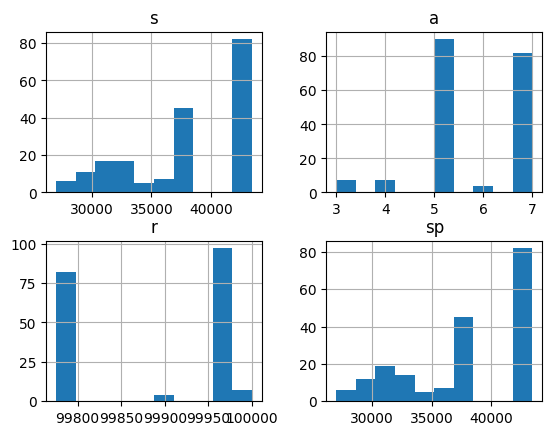

In [29]:
medium_data.head()
print("Unique rewards:", sorted(medium_data['r'].unique()))
print(f"Data contains {len(medium_data['s'].unique())} unique states s")
print(f"Data contains {len(medium_data['sp'].unique())} unique states sp")
print()
print("Action, reward pairs:")
print(medium_data[['a', 'r']].value_counts().sort_index(level=[0, 1]))
print()
print("Data of finishing states (reached flag):")
print(medium_data[medium_data['r'] > 100000 - 250].hist())

Medium Data Observations

Rewards
- Rewards depend only on actions, and whether flag is reached at state.
- $R(s = flag) = +100000$
- $R(a) = -c \cdot |a - 4|$
    - Accelerate most: $a = 1, 7$ with penalty -225. 
    - No acceleration: $a = 4$ with penalty 0.


### Approach


Use Q-learning or SARSA (whichever simpler to implement) to find action-value function $Q(s, a)$.
- Run through data multiple times to update $Q(s, a) \leftarrow Q(s, a) + \alpha (r + \gamma Q(s', a') - Q(s, a))$

In [138]:
n_pos = 500
n_vel = 100
n_actions = 7
Q = np.zeros((n_pos * n_vel + 1, n_actions + 1))

In [139]:
def sarsa(Q, data, iters=1, learning_rate=0.5, discount_rate=1):
    for it in range(iters):
        for i in range(len(data)-1):
            s, a, r, sp = data.iloc[i]
            sp, ap, rp, spp = data.iloc[i+1]
            Q[s, a] += learning_rate * (r + discount_rate * Q[sp, ap] - Q[s, a])
    return Q

In [147]:
def grid_display(data, xdim, ydim, zdim, fig_title=None):
    data = data[1:, 1:].reshape((xdim, ydim, zdim))

    fig, axes = plt.subplots(zdim, figsize=(20, 15), sharex=True, sharey=True)

    # Maximum, minimum value range for colorbar
    vmin, vmax = data.min(), data.max()

    for i in range(7):
        img = axes[i].imshow(data[:, :, i], cmap='viridis', vmin=vmin, vmax=vmax)
        axes[i].set_title(f"Action {i+1}")

    cbar = fig.colorbar(img, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)

    # plt.tight_layout()
    
    # for z in range(1, zdim+1):
    #     print(f"Action a={z}")
    #     img = axes[z-1].matshow(x[1:,z].reshape(xdim, ydim), cmap='viridis', vmin=0, vmax=1)
    #     # plt.colorbar()
    #     plt.colorbar(img, ax=axes[z-1], fraction=0.046, pad=0.04, shrink=0.8)
    if fig_title is not None:
        plt.savefig(f"{fig_title}.png", dpi=300)

In [ ]:
# Q_new = sarsa(Q, medium_data, iters=10)
print(Q)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [144]:
for i in range(8):
    print(i, np.count_nonzero(Q[:, i]))

0 0
1 4744
2 4740
3 10345
4 7484
5 10338
6 4924
7 3829


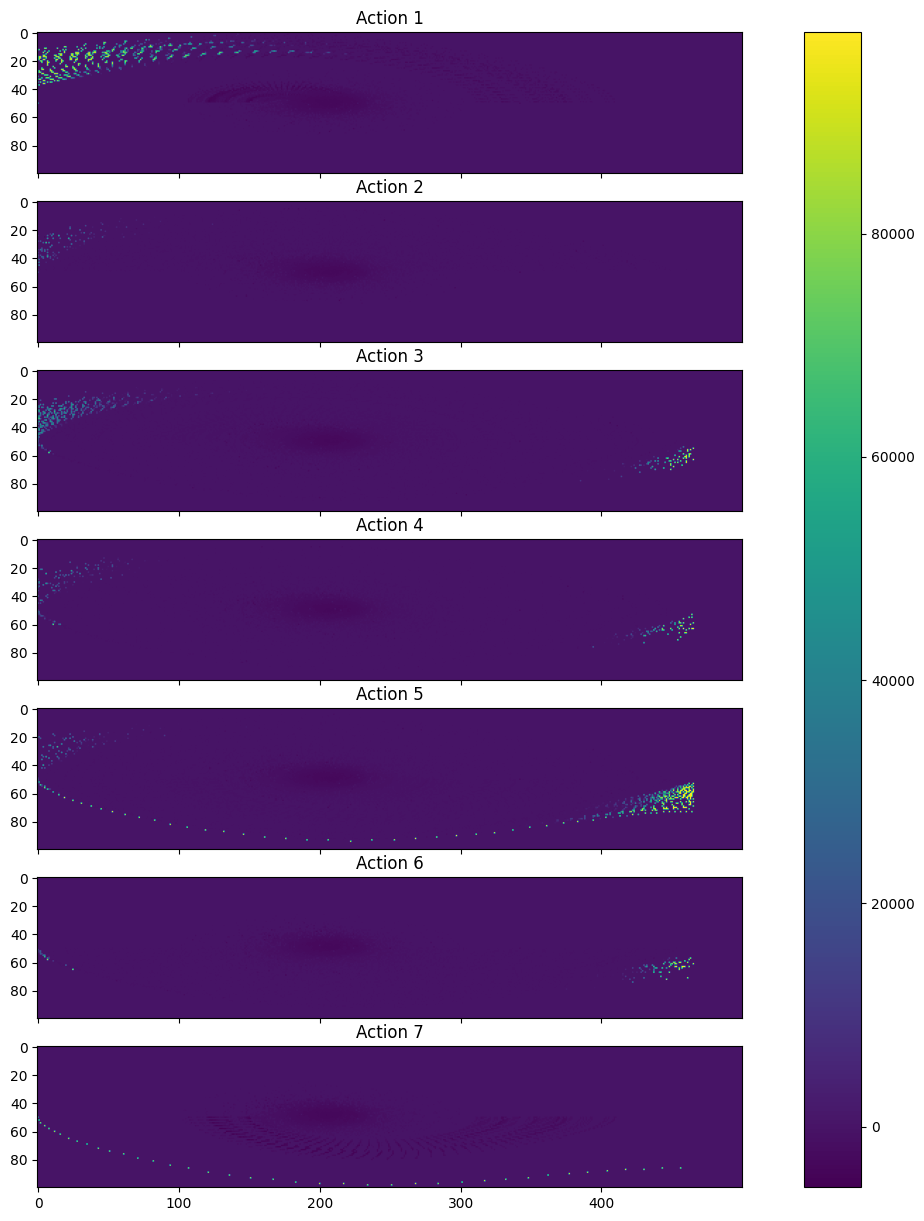

In [148]:
grid_display(Q, n_vel, n_pos, n_actions)#, "medium_Q_sarsa_iters10")